<a href="https://colab.research.google.com/github/AlejoG13/DeepLearning/blob/master/object_detection_JAGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# .0. Ejecutar cada vez que se iniciar sesión

##0.1 Instalar librerias necesarias


---
debemos hacer este proceso siempre que cerremos la sesión, pues por defecto se inicia con tensorflow=2.2 y necesitamos la 1.15


In [11]:
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 36kB/s 
     |████████████████████████████████| 512kB 43.8MB/s 
     |████████████████████████████████| 3.8MB 44.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=17f8348f5a09cda76ff1427999243508fc13205e6aa2165917f10246711e0720
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: 

In [12]:
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk #serialización de grafos inferenciales

!pip install -q Cython contextlib2 pillow lxml matplotlib  #librerias para visualizar imagenes

!pip install -q pycocotools  #para trabajar con unas herramientas de http://cocodataset.org/

!pip install -q watermark   #imprimir marcas de fecha y hora, números de versión e información de hardware.

#esta libreria es obligatoria desde el 2020/05/28
!pip install tf_slim

Selecting previously unselected package python-bs4.
(Reading database ... 144467 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpacking pyt

In [13]:
!python3 --version
%load_ext watermark
print("--Computer vision(hardware)--")
%watermark
%watermark -a "--Computer vision(libraries)--" -u -d -v -p numpy,tensorflow,pycocotools

Python 3.6.9
--Computer vision(hardware)--
2020-06-04T19:33:00+00:00

CPython 3.6.9
IPython 5.5.0

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.104+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
--Computer vision(libraries)-- 
last updated: 2020-06-04 

CPython 3.6.9
IPython 5.5.0

numpy 1.18.4
tensorflow 2.2.0
pycocotools 2.0.0


In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU NO esta activa para el entorno')
tf.__version__

##0.2 habilitar google drive

---



In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# .1. Ejecutar solo una vez (cuando se crea el proyecto)

---
Se van a descargar los repositorios desde GITHUB y se compilan los archivos de configuración

##.1.1 descargar reporsitorio de GITHUB de tensorflow

In [15]:
#descargamos el repositorio de object_detection que esta en GITHUB
%cd /content/gdrive/My\ Drive/deteccion_objectos
!git clone --quiet https://github.com/tensorflow/models.git
#cambiamos la variable de entorno para que sea ahora la del repositorio clonado
import os
os.environ['PYTHONPATH'] += ':/content/gdrive/My Drive/deteccion_objectos/models/research/:/content/gdrive/My Drive/deteccion_objectos/models/research/slim/'
#compliamos protos
%cd /content/gdrive/My\ Drive/deteccion_objectos/models/research
#compilar protos (generar los archivos .py que van en la carpeta protos/)
!protoc object_detection/protos/*.proto --python_out=.

/content/gdrive/My Drive/deteccion_objectos
fatal: destination path 'models' already exists and is not an empty directory.
/content/gdrive/My Drive/deteccion_objectos/models/research
object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


##.1.2.Parametros para descargar un grafo inferencia preentrenado


---
Usaremos el grafo inferencial preentrenado ssd_mobilenet_v2


In [16]:
#variables con las rutas de nuestras dataset de entrenamiento
test_record_fname     = '/content/gdrive/My Drive/deteccion_objectos/TFRecords/test.record'
train_record_fname    = '/content/gdrive/My Drive/deteccion_objectos/TFRecords/train.record'
label_map_pbtxt_fname = '/content/gdrive/My Drive/deteccion_objectos/configuracion/label_map.pbtxt'

# número de pasos (epochs) que usaremos para entrenar
num_steps = 2000  # 200000

# número de evaluaciones por pasos (cada 50 pasos evaluamos el modelo).
num_eval_steps = 50

# Selecionamos el archivo de configuración del modelo
selected_model = 'ssd_mobilenet_v2'

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}

# definimos el tamaño del lote de entrenamiento para uso en la memoria de 
# la GPU Tesla K80 de Colaborate para el modelo seleccionado.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

# Nombre del modelo de detección de objectos que usaremos
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Nombre del archivo de canalización en la API de detección de objetos de tensorflow.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

pipeline_fname = os.path.join('/content/gdrive/My Drive/deteccion_objectos/models/research/object_detection/samples/configs/', pipeline_file)
print("pipeline_fname:"+pipeline_fname)

pipeline_fname:/content/gdrive/My Drive/deteccion_objectos/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config


##.1.3. Descargamos el grafo preentreando ssd_mobilenet_v2

In [17]:
# ubicación de la carpeta base
%cd /content/gdrive/My\ Drive/deteccion_objectos/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# ubicación donde guardaremos el grafo preentrenado que descargamos
DEST_DIR = '/content/gdrive/My Drive/deteccion_objectos/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

# listamos los archivos descargados
!echo $DEST_DIR
!ls -alh pretrained_model

/content/gdrive/My Drive/deteccion_objectos/models/research
/content/gdrive/My Drive/deteccion_objectos/models/research/pretrained_model
total 135M
-rw------- 1 root root   77 Mar 30  2018 checkpoint
-rw------- 1 root root  67M Mar 30  2018 frozen_inference_graph.pb
-rw------- 1 root root  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw------- 1 root root  15K Mar 30  2018 model.ckpt.index
-rw------- 1 root root 3.4M Mar 30  2018 model.ckpt.meta
-rw------- 1 root root 4.2K Mar 30  2018 pipeline.config
drwx------ 3 root root 4.0K Mar 30  2018 saved_model


##.1.4 Modificamos el archivo de configuración del grafo

---
AGregaremos los .records que crearemos más adelante


In [18]:
# Nombre del archivo de canalización en la API de detección de objetos de tensorflow.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

pipeline_fname = os.path.join('/content/gdrive/My Drive/deteccion_objectos/models/research/object_detection/samples/configs/', pipeline_file)
print("pipeline_fname:"+pipeline_fname)

fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint
%cd /content/gdrive/My\ Drive/deteccion_objectos/models/research

pipeline_fname:/content/gdrive/My Drive/deteccion_objectos/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config
/content/gdrive/My Drive/deteccion_objectos/models/research


###1.4.1. configurar la canalización en la API de detección de objetos de tensorflow)

In [0]:
import os

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

###1.4.2.Modificamos el archivo de configuración del grafo con los parametros personalizados de nuestros proyecto.

In [0]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # punto de control de inicio
    s = re.sub('fine_tune_checkpoint: ".*?"','fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # ubicación de los tfrecords de train y test
    s = re.sub('(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub('(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # ubicación del labelmap.pbtxt
    s = re.sub('label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Establecemos el tamaño del lote de entrenamiento
    s = re.sub('batch_size: [0-9]+','batch_size: {}'.format(batch_size), s)

    # Establecemos la cantidad de pasos de entrenamiento
    s = re.sub('num_steps: [0-9]+','num_steps: {}'.format(num_steps), s)
    
    # establecemos el número de clases (etiquetas)
    s = re.sub('num_classes: [0-9]+','num_classes: {}'.format(num_classes), s)
    f.write(s)

###.1.4.3.revisamos que todo quede bien

In [21]:
print(pipeline_fname)
!cat pipeline_fname
!cat /content/gdrive/My\ Drive/deteccion_objectos/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config

/content/gdrive/My Drive/deteccion_objectos/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config
cat: pipeline_fname: No such file or directory
# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 3
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator 

In [0]:
model_dir = '/content/gdrive/My Drive/deteccion_objectos/models/research/training/'

##.1.5.creando los listados csv

In [23]:
# Convierte los archivos xml que estan en la carpeta de entrenamiento a una lista CSV 
# y genera el archivo label_map.pbtxt en el directorio configuracion
!python /content/gdrive/My\ Drive/deteccion_objectos/xml_a_csv_v2.py \
--inputDir /content/gdrive/My\ Drive/deteccion_objectos/img_entrenamiento \
--outputFile /content/gdrive/My\ Drive/deteccion_objectos/csv/train_labels.csv \
--labelMapDir /content/gdrive/My\ Drive/deteccion_objectos/configuracion

Successfully converted xml to csv.
Generate `/content/gdrive/My Drive/deteccion_objectos/configuracion/label_map.pbtxt`


In [16]:
# Convierte los archivos xml que estan en la carpeta de test a una lista CSV
!python /content/gdrive/My\ Drive/deteccion_objectos/xml_a_csv_v2.py \
--inputDir /content/gdrive/My\ Drive/deteccion_objectos/img_test \
--outputFile /content/gdrive/My\ Drive/deteccion_objectos/csv/test_labels.csv

Successfully converted xml to csv.


##.1.6.creando los TFRecords

In [17]:
# Generando el archivo  train.record
!python /content/gdrive/My\ Drive/deteccion_objectos/csv_a_tf_v2.py \
--csv_input=/content/gdrive/My\ Drive/deteccion_objectos/csv/train_labels.csv \
--output_path=/content/gdrive/My\ Drive/deteccion_objectos/TFRecords/train.record \
--img_path=/content/gdrive/My\ Drive/deteccion_objectos/img_entrenamiento \
--label_map /content/gdrive/My\ Drive/deteccion_objectos/configuracion/label_map.pbtxt



W0604 04:24:44.094814 140199162881920 module_wrapper.py:139] From /content/gdrive/My Drive/deteccion_objectos/csv_a_tf_v2.py:105: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0604 04:24:44.647152 140199162881920 module_wrapper.py:139] From /content/gdrive/My Drive/deteccion_objectos/csv_a_tf_v2.py:51: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/gdrive/My Drive/deteccion_objectos/TFRecords/train.record


In [18]:
# Generando el archivo  test.record
!python /content/gdrive/My\ Drive/deteccion_objectos/csv_a_tf_v2.py \
--csv_input /content/gdrive/My\ Drive/deteccion_objectos/csv/test_labels.csv \
--output_path /content/gdrive/My\ Drive/deteccion_objectos/TFRecords/test.record \
--img_path /content/gdrive/My\ Drive/deteccion_objectos/img_test \
--label_map /content/gdrive/My\ Drive/deteccion_objectos/configuracion/label_map.pbtxt



W0604 04:25:16.290567 139834436503424 module_wrapper.py:139] From /content/gdrive/My Drive/deteccion_objectos/csv_a_tf_v2.py:105: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0604 04:25:16.840565 139834436503424 module_wrapper.py:139] From /content/gdrive/My Drive/deteccion_objectos/csv_a_tf_v2.py:51: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/gdrive/My Drive/deteccion_objectos/TFRecords/test.record


#.2. Entrenamiento y reentrenamiento

---


definiendo variables de entorno

##.2.1. parametros para el entrenamiento

In [0]:
import os
os.environ['PYTHONPATH'] = '/env/python:/content/gdrive/My Drive/deteccion_objectos/models/research/:/content/gdrive/My Drive/deteccion_objectos/models/research/slim/'
#os.environ['PYTHONPATH'] =   '/content/gdrive/My Drive/deteccion_objectos/models/research'
#os.environ['PYTHONPATH'] += ':/content/gdrive/My Drive/deteccion_objectos/models/research/slim'
#os.environ['PYTHONPATH'] += ':/content/gdrive/My Drive/deteccion_objectos/models/research/object_detection/protos'

In [25]:
!echo $PYTHONPATH

/env/python:/content/gdrive/My Drive/deteccion_objectos/models/research/:/content/gdrive/My Drive/deteccion_objectos/models/research/slim/


In [34]:
#variables con las rutas de nuestras dataset de entrenamiento
test_record_fname     = '/content/gdrive/My Drive/deteccion_objectos/TFRecords/test.record'
train_record_fname    = '/content/gdrive/My Drive/deteccion_objectos/TFRecords/train.record'
label_map_pbtxt_fname = '/content/gdrive/My Drive/deteccion_objectos/configuracion/label_map.pbtxt'

# número de pasos (epochs) que usaremos para entrenar
num_steps = 15000  # 200000

# número de evaluaciones por pasos (cada 50 pasos evaluamos el modelo).
num_eval_steps = 50

# Selecionamos el archivo de configuración del modelo
selected_model = 'ssd_mobilenet_v2'

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}

# definimos el tamaño del lote de entrenamiento para uso en la memoria de 
# la GPU Tesla K80 de Colaborate para el modelo seleccionado.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

# Nombre del modelo de detección de objectos que usaremos
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Nombre del archivo de canalización en la API de detección de objetos de tensorflow.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

pipeline_fname = os.path.join('/content/gdrive/My Drive/deteccion_objectos/models/research/object_detection/samples/configs/', pipeline_file)
print("pipeline_fname:"+pipeline_fname)

model_dir = '/content/gdrive/My Drive/deteccion_objectos/models/research/training/'

pipeline_fname:/content/gdrive/My Drive/deteccion_objectos/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config


##.2.2. Crear carpeta necesaria para entrenar (solo una vez)


---
(una vez creada no se debe ejecutar otra vez o perdemos todo)


In [27]:
# Recuerden este codigo se hace una sola vez (de lo contrario perderan el entrenamiento)
# la carpeta se debe crear en /content/gdrive/My Drive/deteccion_objectos/models/research/
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)
print(model_dir)

/content/gdrive/My Drive/deteccion_objectos/models/research/training/


##.2.3. habilitar tensorboard (opcional)

###2.3.1 opción 1

In [0]:
#descargar y descomprimir el servidor de tensorboard
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

In [0]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format('/content/gdrive/My Drive/deteccion_objectos/models/research/training/')
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

###2.3.2 opción 2

In [0]:
!pip install tensorboardcolab

In [0]:
tbc=TensorBoardColab()

###.2.3.3.generar el link de tensorboard

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

##.2.4 A entrenar se dijo!!!

In [28]:
#aca podemos revisar algunos de los parametros que vamos a tener presente para entrenar
print ("---archivos necesarios para el entremiento---\n")
print("pipeline_fname: "+pipeline_fname)
print("model_dir: "+model_dir)
print("\n---parametros para el entrenamiento---")
print("num_steps: "+str(num_steps))
print("num_eval_steps: "+str(num_eval_steps))

---archivos necesarios para el entremiento---

pipeline_fname: /content/gdrive/My Drive/deteccion_objectos/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config
model_dir: /content/gdrive/My Drive/deteccion_objectos/models/research/training/

---parametros para el entrenamiento---
num_steps: 15000
num_eval_steps: 50


###.2.4.1 opcion 1 para entrenar

In [0]:
!python /content/gdrive/My\ Drive/deteccion_objectos/models/research/object_detection/model_main.py \
    --pipeline_config_path /content/gdrive/My\ Drive/deteccion_objectos/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config \
    --model_dir  /content/gdrive/My\ Drive/deteccion_objectos/models/research/training/ \
    --alsologtostderr \
    --num_train_steps 2000 \
    --num_eval_steps 50

###.2.4.2 opcion 2 para entrenar usando de forma heredada

In [29]:
%cd /content
# Forma de entrenamiento heredada (también funciona y mucho mejor).
!python /content/gdrive/My\ Drive/deteccion_objectos/models/research/object_detection/legacy/train.py \
--alsologtostderr \
--train_dir /content/gdrive/My\ Drive/deteccion_objectos/models/research/training \
--pipeline_config_path /content/gdrive/My\ Drive/deteccion_objectos/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config

# !python /content/gdrive/My\ Drive/deteccion_objectos/models/research/object_detection/legacy/train.py --logtostderr --train_dir /content/gdrive/My\ Drive/deteccion_objectos/models/research/training/ --pipeline_config_path content/gdrive/My\ Drive/deteccion_objectos/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config 

/content
Instructions for updating:
Use object_detection/model_main.py.
W0604 19:35:57.005384 140424048752512 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/absl/app.py:250: main (from __main__) is deprecated and will be removed in a future version.
Instructions for updating:
Use object_detection/model_main.py.
Instructions for updating:
Please switch to tf.train.create_global_step
W0604 19:35:57.211598 140424048752512 deprecation.py:323] From /content/gdrive/My Drive/deteccion_objectos/models/research/object_detection/legacy/trainer.py:265: create_global_step (from tf_slim.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.create_global_step
W0604 19:35:57.233990 140424048752512 dataset_builder.py:84] num_readers has been reduced to 1 to match input file shards.
Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
W0604 19:35:57.241020 140424048752512 deprecation.py:323]

#.3. Congelando el grafo inferencial según ultimo checkpoint 

---

Una vez que se completa su trabajo de entrenamiento, debe extraer el gráfico de inferencia recién entrenado, que luego se utilizará para realizar la detección de objetos. Esto puede hacerse de la siguiente manera:

In [0]:
#eliminamos la carpeta donde se guarda el grafo inferencial congelado
import shutil
shutil.rmtree('/content/gdrive/My Drive/deteccion_objectos/models/research/fine_tuned_model')

In [36]:
#generamos el nombre el ultimo checkpoint valido de entrenamiento
import re
import numpy as np

%cd /content/gdrive/My\ Drive/deteccion_objectos/models/research

output_directory = '/content/gdrive/My Drive/deteccion_objectos/models/research/fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)

/content/gdrive/My Drive/deteccion_objectos/models/research
/content/gdrive/My Drive/deteccion_objectos/models/research/training/model.ckpt-6512


In [46]:
#generamos el grafo inferencias congelado
!python /content/gdrive/My\ Drive/deteccion_objectos/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path='/content/gdrive/My Drive/deteccion_objectos/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config' \
    --output_directory='/content/gdrive/My Drive/deteccion_objectos/models/research/fine_tuned_model' \
    --trained_checkpoint_prefix='/content/gdrive/My Drive/deteccion_objectos/models/research/training/model.ckpt-6417'

Instructions for updating:
Please use `layer.__call__` method instead.
W0604 20:45:14.819279 140089487669120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0604 20:45:17.218275 140089487669120 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0604 20:45:17.260724 140089487669120 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0604 20:45:17.415123 140089487669120 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv befo

#.4. Exportando el grafo inferencial en un archivo serializado (.PB)

In [47]:
import os
output_directory='/content/gdrive/My Drive/deteccion_objectos/models/research/fine_tuned_model'
pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")

assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)
!ls -alh {pb_fname}
from google.colab import files
#descargamos el modelo
files.download(pb_fname)
#descargamos el mapa de etiquetas.
files.download(label_map_pbtxt_fname)

ls: cannot access '/content/gdrive/My': No such file or directory
ls: cannot access 'Drive/deteccion_objectos/models/research/fine_tuned_model/frozen_inference_graph.pb': No such file or directory


#.5. probando el grafo de inferencia.

In [50]:
import os
import glob

# Ruta del gráfo de detección congelado. Este es el modelo real que se utiliza para la detección de objetos.
PATH_TO_CKPT = pb_fname

# Lista de las cadenas que se utilizan para agregar la etiqueta correcta para cada cuadro.
PATH_TO_LABELS = label_map_pbtxt_fname

# ruta donde estan las imágenes para probar
PATH_TO_TEST_IMAGES_DIR =  "/content/gdrive/My Drive/deteccion_objectos/img_prueba"

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

#número de clases a las que se liminara el grafo.
num_classes = 3

['/content/gdrive/My Drive/deteccion_objectos/img_prueba/buho18.jpg', '/content/gdrive/My Drive/deteccion_objectos/img_prueba/buho19.jpg', '/content/gdrive/My Drive/deteccion_objectos/img_prueba/colibri10.jpg', '/content/gdrive/My Drive/deteccion_objectos/img_prueba/colibri14.jpg', '/content/gdrive/My Drive/deteccion_objectos/img_prueba/colibri15.jpg', '/content/gdrive/My Drive/deteccion_objectos/img_prueba/colibri19.jpg', '/content/gdrive/My Drive/deteccion_objectos/img_prueba/colibri17.jpg', '/content/gdrive/My Drive/deteccion_objectos/img_prueba/buho17.jpg', '/content/gdrive/My Drive/deteccion_objectos/img_prueba/random7.jpg', '/content/gdrive/My Drive/deteccion_objectos/img_prueba/random6.jpg', '/content/gdrive/My Drive/deteccion_objectos/img_prueba/random4.jpg', '/content/gdrive/My Drive/deteccion_objectos/img_prueba/random5.jpg', '/content/gdrive/My Drive/deteccion_objectos/img_prueba/random3.jpg', '/content/gdrive/My Drive/deteccion_objectos/img_prueba/paloma20.jpg', '/content/g

/content/gdrive/My Drive/deteccion_objectos/models/research/object_detection
/content/gdrive/My Drive/deteccion_objectos/img_prueba/buho18.jpg
/content/gdrive/My Drive/deteccion_objectos/img_prueba/buho19.jpg
/content/gdrive/My Drive/deteccion_objectos/img_prueba/colibri10.jpg
/content/gdrive/My Drive/deteccion_objectos/img_prueba/colibri14.jpg
/content/gdrive/My Drive/deteccion_objectos/img_prueba/colibri15.jpg
/content/gdrive/My Drive/deteccion_objectos/img_prueba/colibri19.jpg
/content/gdrive/My Drive/deteccion_objectos/img_prueba/colibri17.jpg
/content/gdrive/My Drive/deteccion_objectos/img_prueba/buho17.jpg
/content/gdrive/My Drive/deteccion_objectos/img_prueba/random7.jpg
/content/gdrive/My Drive/deteccion_objectos/img_prueba/random6.jpg
/content/gdrive/My Drive/deteccion_objectos/img_prueba/random4.jpg
/content/gdrive/My Drive/deteccion_objectos/img_prueba/random5.jpg
/content/gdrive/My Drive/deteccion_objectos/img_prueba/random3.jpg
/content/gdrive/My Drive/deteccion_objectos/i

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


/content/gdrive/My Drive/deteccion_objectos/img_prueba/paloma17.jpg
/content/gdrive/My Drive/deteccion_objectos/img_prueba/paloma11.jpg
/content/gdrive/My Drive/deteccion_objectos/img_prueba/colibri18.jpg
/content/gdrive/My Drive/deteccion_objectos/img_prueba/colibri20.jpg


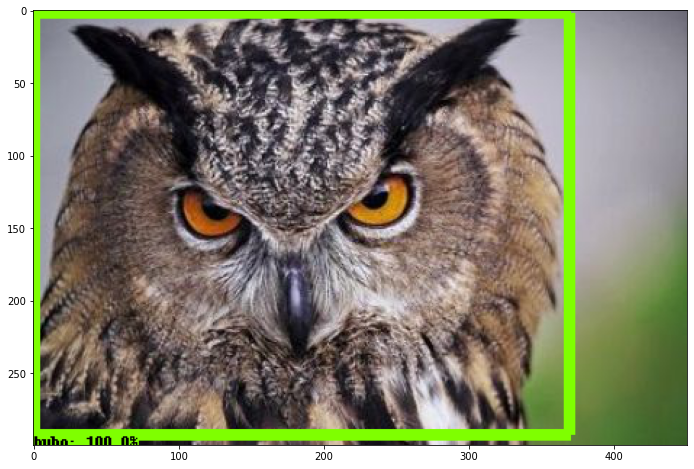

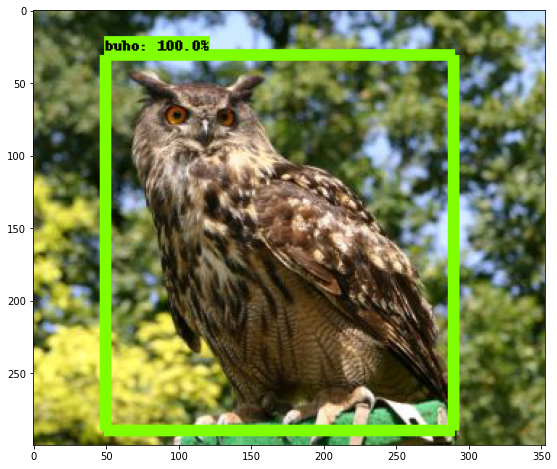

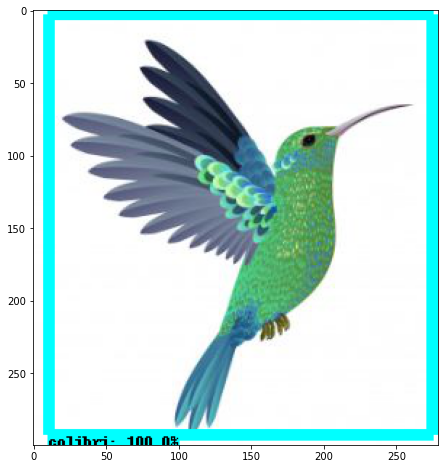

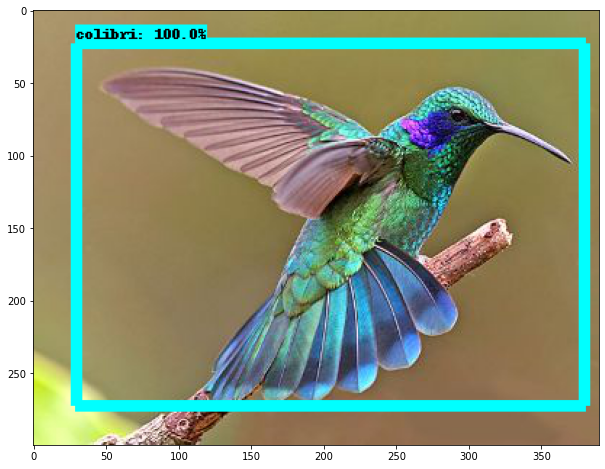

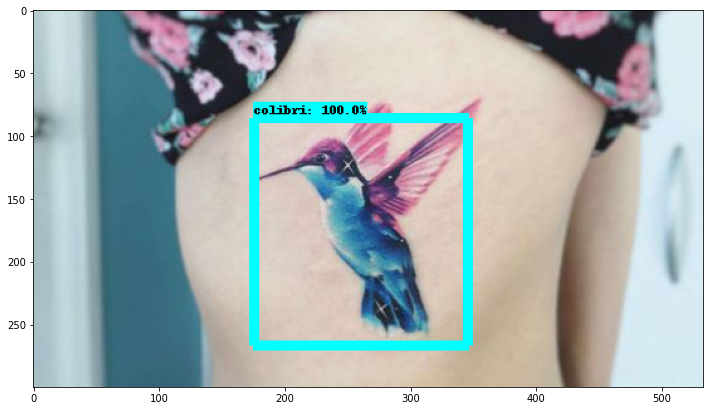

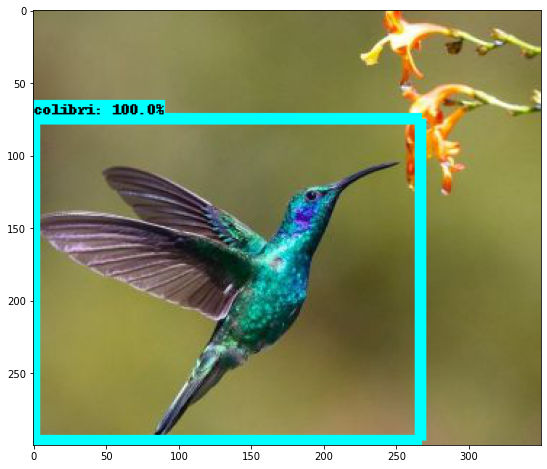

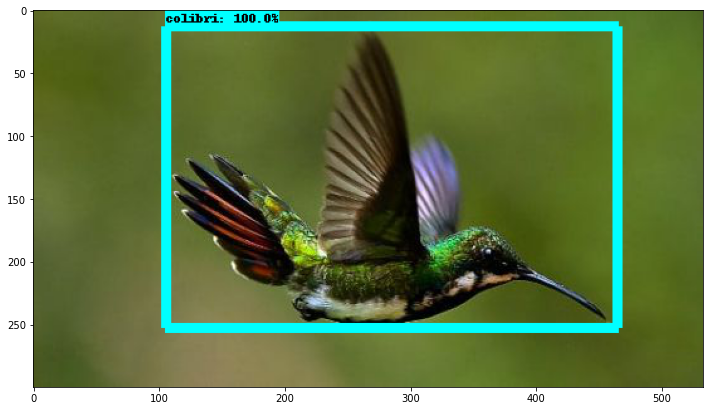

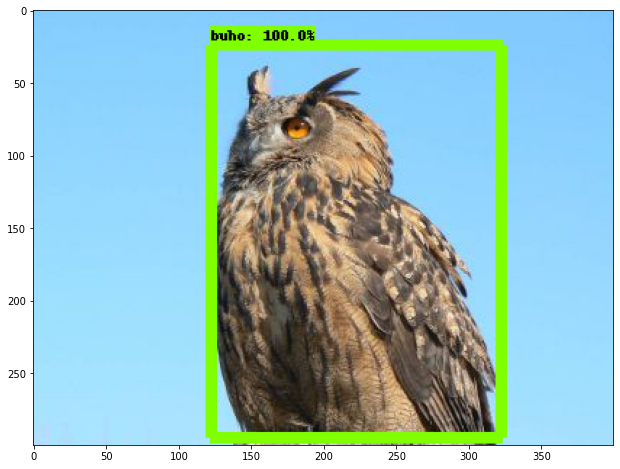

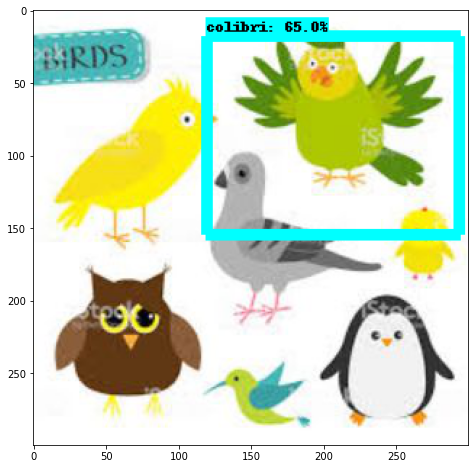

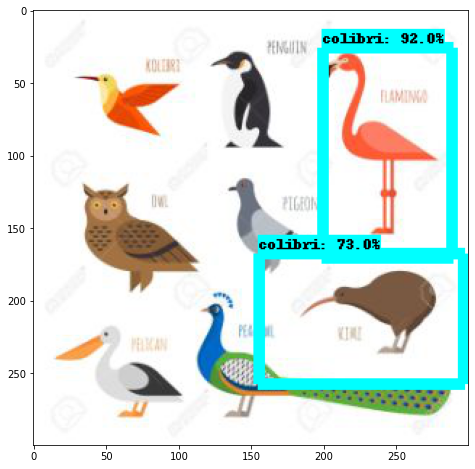

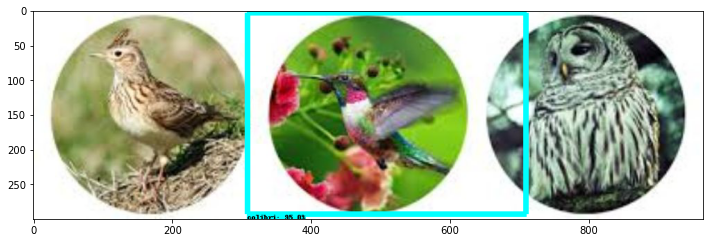

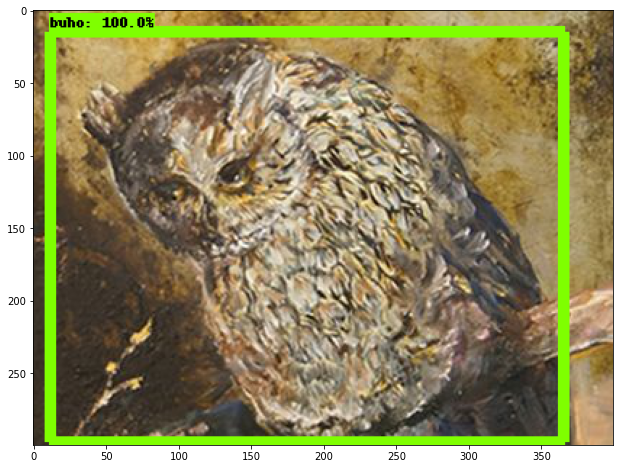

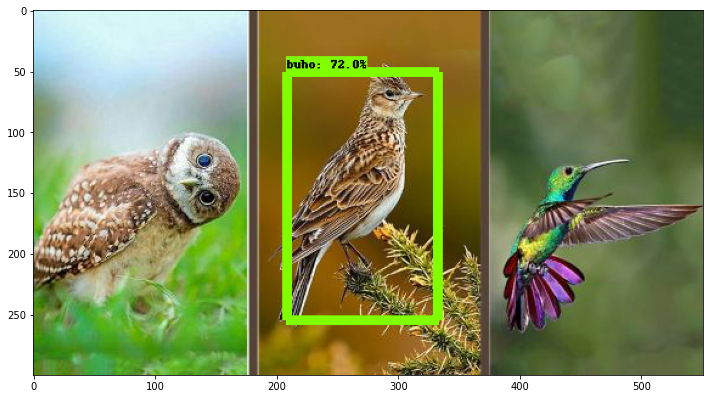

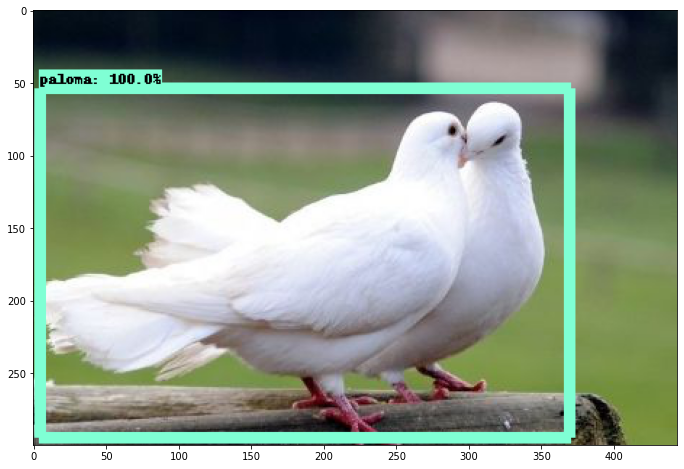

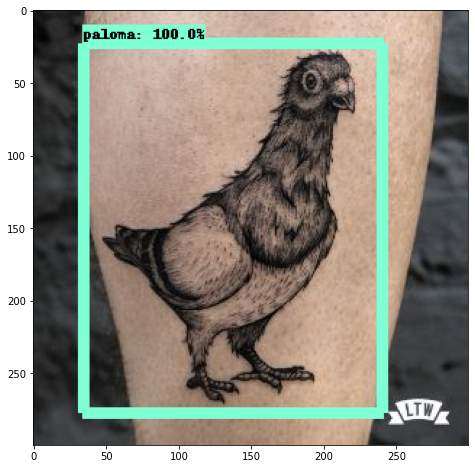

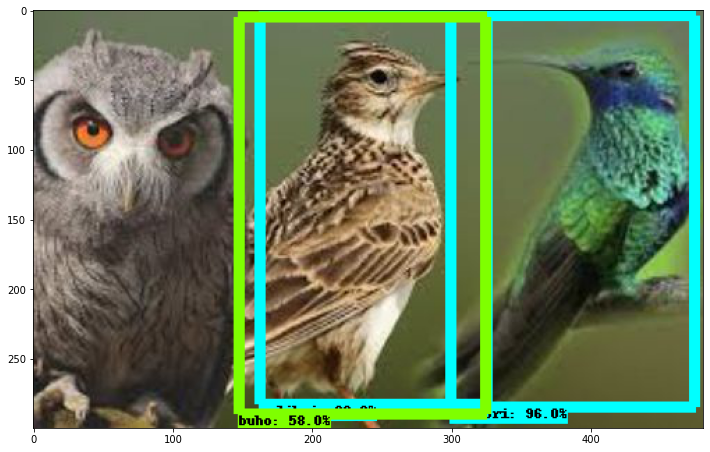

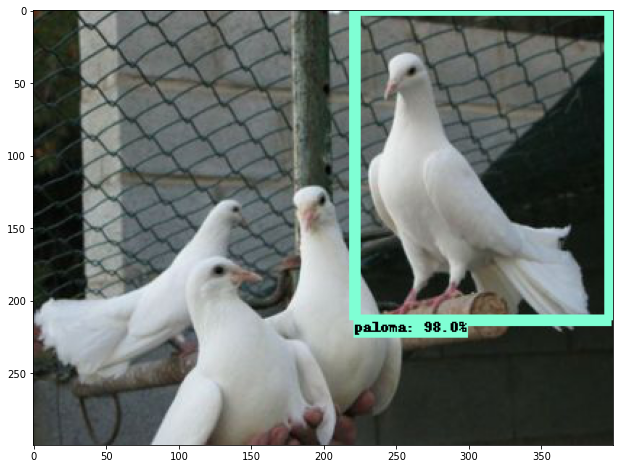

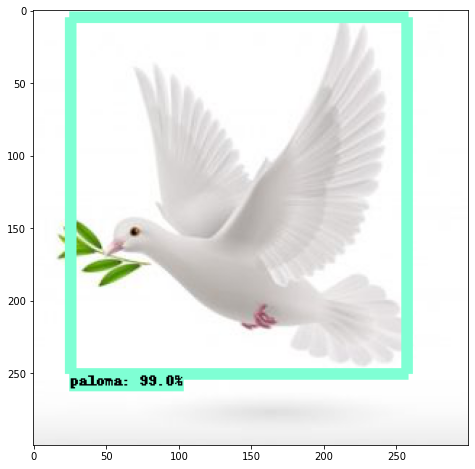

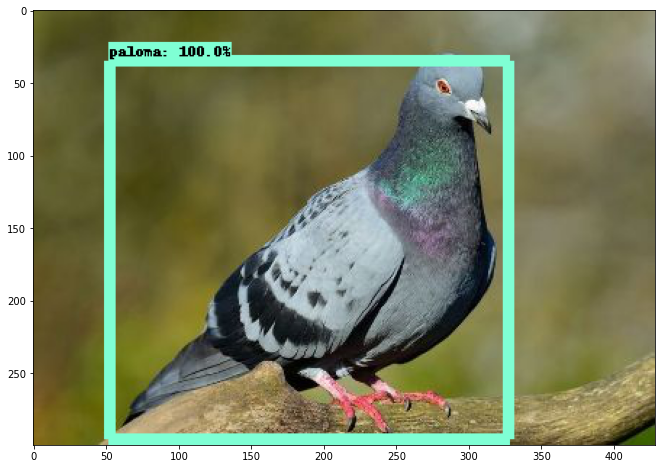

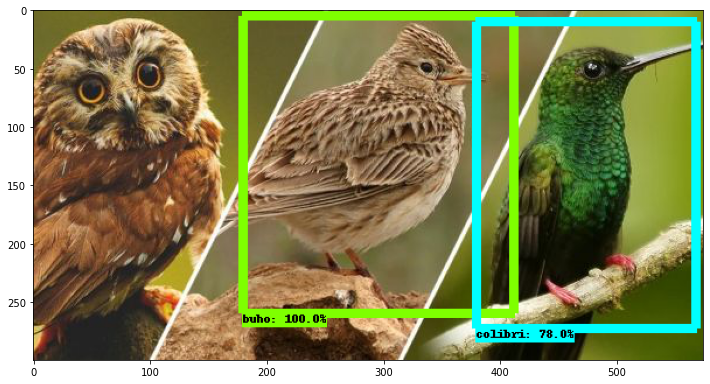

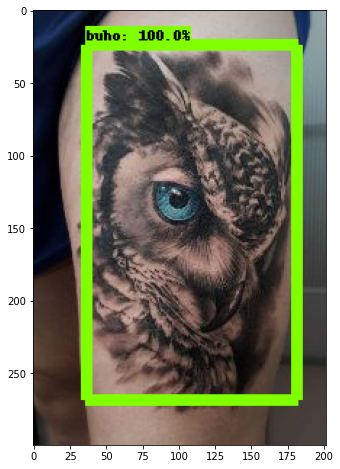

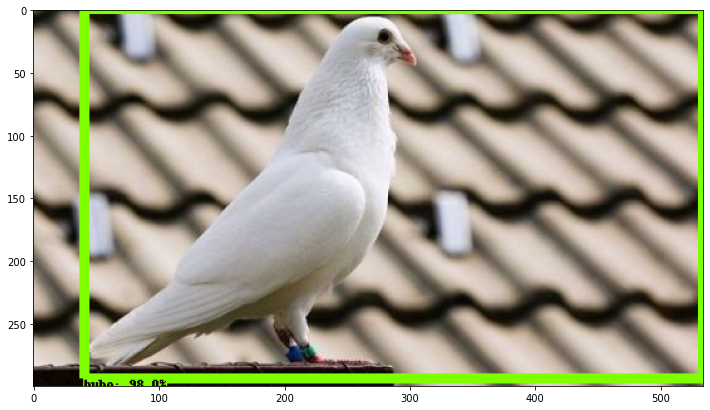

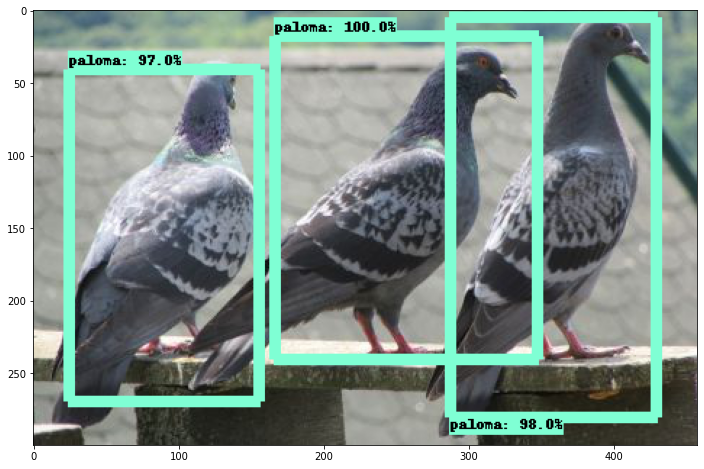

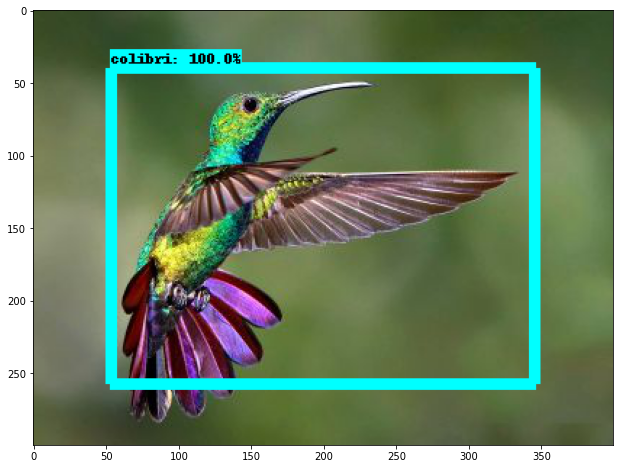

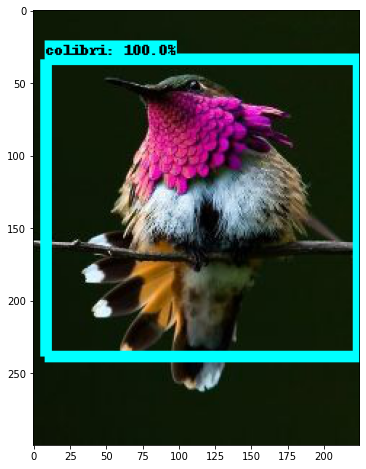

In [51]:
%cd /content/gdrive/My\ Drive/deteccion_objectos/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

sys.path.append("..")
from object_detection.utils import ops as utils_ops

#Esto es necesario para mostrar las imágenes.
%matplotlib inline

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

#funcion para analizar inferencia en una imagen
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Obtenga manijas para tensores de entrada y salida
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # El siguiente procesamiento es solo para una sola imagen
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Es necesario volver a enmarcar para traducir la máscara de las coordenadas del cuadro a las coordenadas de la imagen y ajustar el tamaño de la imagen.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Siga la convención agregando nuevamente la dimensión del lote
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,feed_dict={image_tensor: np.expand_dims(image, 0)})

            # todas las salidas son matrices numpy float32, así que convierta los tipos según corresponda
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
  print(image_path)
  image = Image.open(image_path)
  # la representación basada en matriz de la imagen se usará más adelante para preparar la imagen resultante con cuadros y etiquetas.
  image_np = load_image_into_numpy_array(image)
  # Amplíe las dimensiones ya que el modelo espera que las imágenes tengan forma: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # deteción actual
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualización de los resultados de una detección.
  vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks'),
    use_normalized_coordinates=True,
    line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

#.6.Exportando grafo a un formato lite (celulares y raspberry).

In [0]:
DEST_DIR='/content/gdrive/My Drive/deteccion_objectos/models/research/pretrained_model'
fine_tune_checkpoint = os.path.join("/content/gdrive/My Drive/deteccion_objectos/models/research/pretrained_model", "model.ckpt")
#!echo {DEST_DIR}
#!ls -alh {DEST_DIR}
print("fine_tune_checkpoint: "+fine_tune_checkpoint)
print("pb_fname: "+pb_fname)
print("pipeline_fname: "+pipeline_fname)
print("model_dir: "+model_dir)
!ls -alh /content/gdrive/My\ Drive/deteccion_objectos/models/research/training/

In [0]:
!python /content/gdrive/My\ Drive/deteccion_objectos/models/research/object_detection/export_tflite_ssd_graph.py \
--pipeline_config_path=/content/gdrive/My\ Drive/deteccion_objectos/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config \
--trained_checkpoint_prefix=/content/gdrive/My\ Drive/deteccion_objectos/models/research/training/model.ckpt-663 \
--output_directory=/content/gdrive/My\ Drive/deteccion_objectos/models/research/tflite \
--add_postprocessing_op=true

In [0]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_saved_model("/content/modelo_salvado")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()